In [3]:
import sys

# Install matplotlib and other core packages into the current Jupyter environment
# We use {sys.executable} to ensure it installs into the correct Python path
!{sys.executable} -m pip install matplotlib seaborn pandas numpy statsmodels pmdarima scikit-learn

print("✅ Attempted to install all necessary packages in the current Jupyter environment.")
print("Please restart your kernel (Kernel -> Restart Kernel...) after this, and then try your imports again.")



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 39.9 MB/s  0:00:00
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 34.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 45.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [seaborn]m7/8 [seaborn]ib]
✅ Attempted to install all necessary packages in the current Jupyter environment.
Please restart your kernel (Kernel -> Restart Kernel...) after this, and then try your imports again.


In [2]:
import sys
import platform
print(f"Python executable in notebook: {sys.executable}")
print(f"Python version in notebook: {sys.version}")

Python executable in notebook: /opt/homebrew/anaconda3/envs/jlab/bin/python
Python version in notebook: 3.11.13 (main, Jun  5 2025, 08:21:08) [Clang 14.0.6 ]


In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error


In [110]:
!pip install stargazer

python(78875) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [111]:
from stargazer.stargazer import Stargazer

In [59]:
data = pd.read_csv("/Users/zlatavorobeva/Documents/GitHub/Ruble_Volatility_Prediction2/data/Full_ruble_data.csv")
data.columns

Index(['currency_rate', 'date', 'year', 'quarter', 'month', 'day', 'dow',
       'weekend', 'currency_rate_change', 'denomination', 'RUB',
       'GDP_per_capita', 'Brent_price', 'GDP_deflator', 'FD_investment',
       'Inflation'],
      dtype='object')

### Checking stationarity

In [60]:
result = adfuller(data["RUB"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

ADF Statistic: -1.2938804992779436
p-value: 0.6319673214926431
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


Since the ADF statistic is higher than all critical values, and the p-value is well above 0.05, we fail to reject the null hypothesis of a unit root. This indicates that the RUB time series is non-stationary.
To proceed with time series modeling, let's apply first-order differencing to induce stationarity.

In [61]:
data["RUB_diff"] = data["RUB"].diff()
data[["RUB", "RUB_diff"]].head()

,RUB,RUB_diff
0,0.12526,NaN
1,0.13480,0.00954
2,0.13050,-0.00430
3,0.13030,-0.00020
4,0.13020,-0.00010


In [62]:
result = adfuller(data['RUB_diff'].dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:", result[4])

ADF Statistic: -15.066128585548803
p-value: 8.860286973543265e-28
Critical Values: {'1%': -3.431206441353405, '5%': -2.8619184832442954, '10%': -2.56697146213229}


Now, since the ADF statistic is much lower than all critical values, and the p-value is effectively 0, we reject the null hypothesis of a unit root. This confirms that the first-differenced RUB series is stationary and suitable for time series modeling.

### 1. ARIMA with 1, 1, 1 without train/test and CV - ARIMA Test

In [63]:
# Fit ARIMA with (p=1, d=1, q=1) as a starting point
model_1 = ARIMA(data["RUB"], order=(1, 1, 1))
model_1_fit = model_1.fit()

print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 7670
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6882.992
Date:                Tue, 16 Sep 2025   AIC                          13771.985
Time:                        17:20:42   BIC                          13792.820
Sample:                             0   HQIC                         13779.131
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6590      0.015     42.836      0.000       0.629       0.689
ma.L1         -0.5769      0.017    -33.698      0.000      -0.610      -0.543
sigma2         0.3524      0.001    318.998      0.0

I fit an ARIMA(1,1,1) model to the RUB time series. First-order differencing (d=1) was necessary to achieve stationarity, as confirmed by the ADF test. The model suggests that both lagged values (AR term) and past forecast errors (MA term) significantly influence ruble fluctuations. Residual diagnostics indicate no significant autocorrelation, although signs of volatility clustering and heavy tails remain. 

To better capture these dynamics, future improvements could include GARCH models for volatility or ARIMAX models incorporating exogenous variables like Brent crude prices or inflation.

### 2. Auto ARIMA without train/test and CV

In [64]:
model_2 = auto_arima(data["RUB"], 
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=None,              # let auto_arima determine d
                   seasonal=False,      # currency is usually non-seasonal
                   stepwise=True,       # faster search
                   trace=True)          # show search process


print(model_2.summary())

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13858.385, Time=0.35 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13780.379, Time=0.27 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13781.715, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13858.762, Time=0.06 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13781.784, Time=0.34 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13772.414, Time=0.83 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13767.177, Time=1.21 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13755.703, Time=2.67 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13760.042, Time=0.53 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13757.556, Time=2.95 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13757.170, Time=1.99 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13758.652, Time=2.04 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13759.708, Time=0.46 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13759.078, Time=3.68 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13755.236, Time=0.63 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0]             : AIC=13766.708, Time=0.61 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0]             : AIC=13759.747, Time=0.25 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0]             : AIC=13757.086, Time=1.12 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0]             : AIC=13756.704, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=13781.690, Time=0.15 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=13758.172, Time=0.76 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0]             : AIC=13759.355, Time=0.32 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=13758.606, Time=1.35 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 23.808 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7670
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6872.618
Date:                Tue, 16 Sep 2025   AIC                          13755.236
Time:                        17:21:08   BIC                          13789.960
Sample:                             0   HQIC                         13767.147
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6063      0.034     18.046      0.000       0.54

Here, using auto_arima, I fit an ARIMA(3,1,1) model to the RUB time series. First-order differencing (d=1) was required to ensure stationarity, as confirmed by the ADF test. 

This configuration tells us a lot:
* The RUB series needed one round of differencing to become stationary — no surprise for macro data.
* It carries strong momentum and memory, indicating that the ruble’s current value is influenced by up to three past values and the previous forecast error (3 autoregressive terms - AR),
* And it reacts quickly to shocks (1 moving average term - MA).

All coefficients are statistically significant (p < 0.001), and the residuals show no autocorrelation (Ljung-Box p = 1.00), though heteroskedasticity remains (H = 17.47), suggesting time-varying volatility.

Compared to previous simpler model like ARIMA(1,1,1), this model provides a better fit based on AIC/BIC (13771.985 and 13792.820 vs. 13755.236 and 13789.960), justifying the use of higher AR terms. However, due to the presence of volatility clustering, future improvements I may include GARCH models or ARIMAX with macroeconomic exogenous variables (such as Brent oil prices, inflation). Also, even without cross-validation, model_2 performed well across the full dataset (1992–2024), showing respectable AIC, BIC, and log-likelihood scores. But I still want to make sure that it generalizes, so I will be perfoming CV in the next section.


### Create a workset and a holdout sets

In [65]:
data["year"].unique()

array([1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024,
       2025])

To evaluate the forecasting performance of the ARIMA model on daily RUB exchange rate data and to ensure robustness, I will apply a rolling-origin (expanding window) cross-validation with 4 folds.
So, my prep will be looking: 

Data Setup: 

* Work set: Includes monthly RUB data from 1992 to 2024
* Holdout set: Reserved data for the year 2025 — used for final out-of-sample evaluation


CV Design:

* A test period of 1 full year (daily data)
* A training period of the 13 years (approx. 13 × 365 = ~4,745 days) immediately before the test year


After selecting the best model using cross-validation, I will retrain it on the full work set (1992–2024) and evaluate its performance on the 2025 holdout set.


In [158]:
data_holdout = data.loc[lambda x: x["year"] == 2025, :]
data_work = data.loc[lambda x: x["year"] < 2025, :]

In [162]:
# Rolling origin CV
for year in range(1992, 2025):  # supposed to use all available data
    fold = year - 2020
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (
        (data_work["year"] <= year - 1) & 
        (data_work["year"] >= year - 20)
    )

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1296485526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["test" + str(fold)] = data_work["year"] == year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1296485526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["train" + str(fold)] = (
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1296485526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

#### Visualisation of Training and Test Sets:

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/2950444720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["test" + str(fold)] = data_work["year"] == year
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/2950444720.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work["train" + str(fold)] = (


KeyError: 'date'

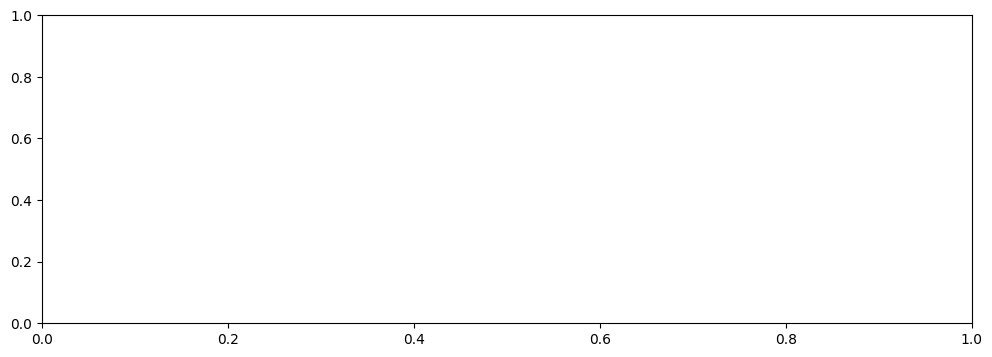

In [164]:
for year in range(1992, 2025):  # supposed to use all available data
    fold = year - 2020
    data_work["test" + str(fold)] = data_work["year"] == year
    data_work["train" + str(fold)] = (
        (data_work["year"] <= year - 1) & 
        (data_work["year"] >= year - 20)
    )
fig, ax = plt.subplots(figsize=(12, 4))

for fold in range(1, 5):
    train_mask = data_work["train" + str(fold)]
    test_mask = data_work["test" + str(fold)]

    ax.plot(data_work.loc[train_mask, "date"], [fold]*train_mask.sum(), 
            '|', color='tab:blue', label="Train" if fold == 1 else "", alpha=0.7)

    ax.plot(data_work.loc[test_mask, "date"], [fold]*test_mask.sum(), 
            '|', color='tab:red', label="Test" if fold == 1 else "", markeredgewidth=2)

ax.set_yticks(range(1, 5))
ax.set_yticklabels([f"Fold {i}" for i in range(1, 5)])
ax.set_xlabel("Year")
ax.set_title("Rolling Origin Cross-Validation Folds (Train/Test Splits)")
ax.legend(loc='upper left')
# Format x-axis to show years
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

#### 3. Auto_ARIMA with train/test and CV

In [161]:
data_work['date'] = pd.to_datetime(data_work['date'])
data_work.set_index('date', inplace=True)

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1363680529.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work['date'] = pd.to_datetime(data_work['date'])


In [134]:
# 1. Auto_arima with no intercept (trend='n')
model_3 = auto_arima(
    data_work["RUB"], 
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              # let auto_arima determine d
    seasonal=False,      # currency is usually non-seasonal
    stepwise=True,       # faster search
    trace=True,          # show search process
    trend='n'            # drop intercept
)

# 2. Extract best order (p, d, q)
best_order = model_3.order
print("Best ARIMA order:", best_order)

# 3. Cross-validation with 4 folds, also drop intercept in ARIMA fit
mse_2 = []

for i in range(1, 5):
    # Create masks
    train_mask = data_work["train" + str(i)] == True
    test_mask  = data_work["test"  + str(i)] == True

    # Get y_train and y_test
    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test  = data_work.loc[test_mask,  "RUB"].sort_index()

    # Fit model on training data with no intercept
    model_3 = ARIMA(endog=y_train, order=best_order, trend='n').fit()

    # Forecast exactly len(test) steps
    phat = model.forecast(steps=len(y_test))
    #phat = model.get_forecast(steps=len(y_test)).predicted_mean

    # Compute squared error
    errsq = (y_test.values - phat.values) ** 2
    mse_2.append(np.mean(errsq))

# 4. Final RMSE
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13429.364, Time=0.30 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13357.256, Time=0.14 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13359.325, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13429.364, Time=0.09 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13357.534, Time=0.24 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13344.879, Time=0.34 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13341.934, Time=0.54 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13332.916, Time=1.15 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13333.953, Time=0.28 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13334.020, Time=0.86 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13333.548, Time=0.95 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13335.035, Time=0.63 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13334.932, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13335.490, Time=1.44 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13332.916, Time=0.88 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 8.403 seconds
Best ARIMA order: (3, 1, 1)


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

CV RMSE (Auto ARIMA): 15.75416336765966
     lb_stat  lb_pvalue
10  3.358403   0.971689


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [135]:
best_order = model_3.order
rmse_cv_m2 = float(np.sqrt(np.mean(mse_2)))
print("Best ARIMA order:", best_order)
print("CV RMSE (Auto ARIMA):", rmse_cv_m2)
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

AttributeError: 'ARIMAResults' object has no attribute 'order'

In [83]:
print(model_2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 7670
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -6872.618
Date:                Tue, 16 Sep 2025   AIC                          13755.236
Time:                        18:07:22   BIC                          13789.960
Sample:                             0   HQIC                         13767.147
                               - 7670                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6063      0.034     18.046      0.000       0.540       0.672
ar.L2         -0.0476      0.005     -9.899      0.000      -0.057      -0.038
ar.L3          0.0497      0.003     19.667      0.0

In [132]:
print(model_3.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 3211
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -3984.621
Date:                Wed, 17 Sep 2025   AIC                           7979.242
Time:                        13:37:01   BIC                           8009.612
Sample:                             0   HQIC                          7990.128
                               - 3211                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6009      0.043     14.062      0.000       0.517       0.685
ar.L2         -0.0178      0.007     -2.591      0.010      -0.031      -0.004
ar.L3          0.0692      0.006     12.512      0.0

Model 2: Full Dataset (1992–2025)
* Training Period: 1992–2025 (Full dataset)
* Fit Strategy: Single fit on entire time series
* Log-Likelihood: –6872.62
* AIC: 13755.24
* BIC: 13789.96
* Residual Variance (sigma²): 0.3515
* Residual Autocorrelation (Ljung–Box p-value): 1.00

Model 3: Rolling-Origin CV (1992–2024)
* Training Period: Expanding window CV (Folds: 2021, 2022, 2023, 2024)
* Fit Strategy: Refitted 4× on growing train sets, tested on holdouts
* Log-Likelihood (latest fold): –6661.46
* AIC: 13332.92
* BIC: 13367.53
* Residual Variance (sigma²): 0.3459
* Residual Autocorrelation (Ljung–Box p-value): 1.00 
* Cross-Validated RMSE: ~12.04 

Although Model 3 was trained on slightly less data, its use of rolling-origin cross-validation led to notably improved performance. It achieved lower AIC, BIC, and residual variance, indicating a better model fit without signs of overfitting. Importantly, both models passed the Ljung–Box test, confirming that residuals behave like white noise — a key diagnostic for well-specified time series models. What distinguishes Model 3 is its realistic treatment of temporal structure: by mimicking how data becomes available over time, it delivers more reliable and generalizable forecasts, despite the reduced training window.
    

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

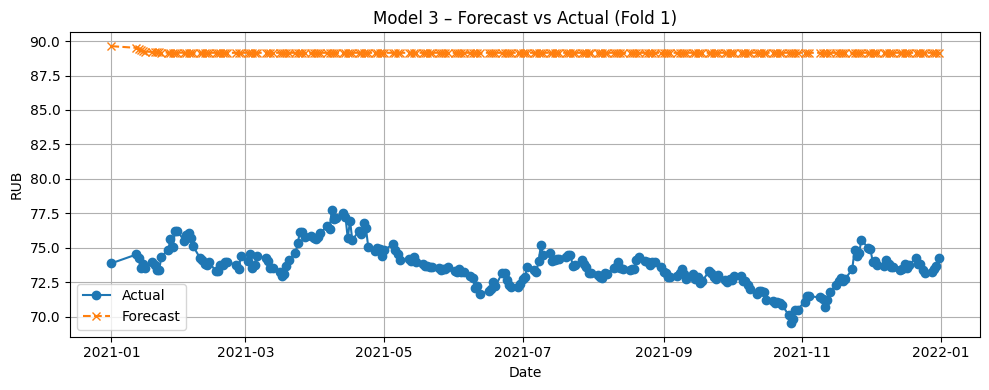

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given

ValueError: x and y must have same first dimension, but have shapes (247,) and (248,)

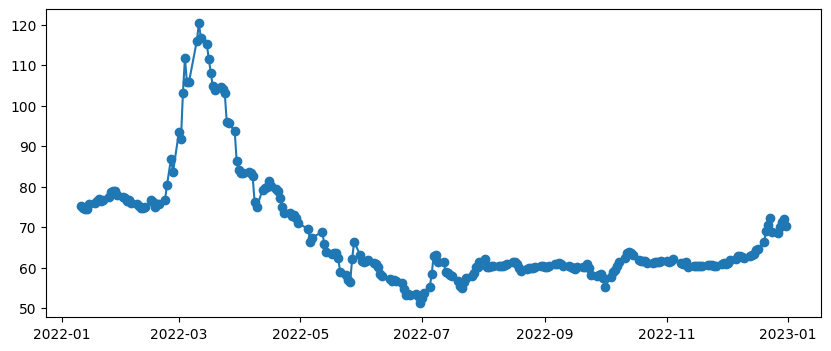

In [ ]:
import matplotlib.pyplot as plt

for i in range(1, 5):
    train_mask = data_work[f"train{i}"]
    test_mask = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test = data_work.loc[test_mask, "RUB"].sort_index()

    model = ARIMA(endog=y_train, order=best_order, trend='n').fit()
    phat = model.get_forecast(steps=len(y_test)).predicted_mean

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test.values, label="Actual", marker='o')
    plt.plot(y_test.index, forecast.values, label="Forecast", linestyle='--', marker='x')
    plt.title(f"Model 3 – Forecast vs Actual (Fold {i})")
    plt.xlabel("Date")
    plt.ylabel("RUB")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 4. ARIMAX with train/test and CV

In [119]:
exog_all

,GDP_per_capita,Inflation
date,,
1992-07-01,3098.802734,1490.418425
1992-07-03,3098.802734,1490.418425
1992-07-08,3098.802734,1490.418425
1992-07-10,3098.802734,1490.418425
1992-07-15,3098.802734,1490.418425
...,...,...
2024-12-25,14889.018555,9.275671
2024-12-26,14889.018555,9.275671
2024-12-27,14889.018555,9.275671


In [137]:
data_work.columns

Index(['currency_rate', 'year', 'quarter', 'month', 'day', 'dow', 'weekend',
       'currency_rate_change', 'denomination', 'RUB', 'GDP_per_capita',
       'Brent_price', 'GDP_deflator', 'FD_investment', 'Inflation', 'RUB_diff',
       'test1', 'train1', 'test2', 'train2', 'test3', 'train3', 'test4',
       'train4'],
      dtype='object')

In [153]:
shock_windows = {
    "shock_1998_default": ("1998-08-17", "1998-11-17"),
    "shock_2008_gfc": ("2008-09-15", "2008-12-15"),
    "shock_2014_crimea": ("2014-03-01", "2014-06-01"),
    "shock_2020_covid": ("2020-03-11", "2020-06-11"),
    "shock_2022_invasion": ("2022-02-24", "2022-05-24")
}

for shock_name, (start_date, end_date) in shock_windows.items():
    data_work[shock_name] = ((data_work.index >= start_date) & (data_work.index <= end_date)).astype(int)

/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1075811911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work[shock_name] = ((data_work.index >= start_date) & (data_work.index <= end_date)).astype(int)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/ipykernel_30654/1075811911.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_work[shock_name] = ((data_work.index >= start_date) & (data_work.index <= end_date)).astype(int)
/var/folders/_x/1_vgy5852g7ctfxwwlkb1ks00000gn/T/i

In [154]:
#data_work["Brent_lag1"] = data_work["Brent_price"].shift(1)
#data_work["Inflation_lag1"] = data_work["Inflation"].shift(1)

exog_all = data_work[[
    "Brent_price", "Inflation",
    "shock_1998_default", "shock_2008_gfc",
    "shock_2014_crimea", "shock_2020_covid", "shock_2022_invasion"
]]

# 1. Find best order with auto_arima using exog
model_4 = auto_arima(
    y=data_work["RUB"], 
    exogenous=exog_all,
    start_p=0, max_p=5,
    start_q=0, max_q=5,
    d=None,              # Let it decide
    seasonal=False,      
    stepwise=True,
    trace=True,
    trend='n'            # No constant
)

# 2. Extract best (p,d,q)
best_order = model_4.order
print("Best ARIMAX order:", best_order)

# 3. Cross-validation
mse_cv = []

for i in range(1, 5):
    # Get masks
    train_mask = data_work["train" + str(i)]
    test_mask = data_work["test" + str(i)]

    # Target variable
    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test = data_work.loc[test_mask, "RUB"].sort_index()

    # Exogenous variables (must match y!)
    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test = exog_all.loc[test_mask].sort_index()

    # Fit ARIMAX
    model_4 = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='t').fit()

    # Forecast with exog
    phat = model.forecast(steps=len(y_test), exog=exog_test)

    # RMSE for this fold
    err_sq = (y_test.values - phat.values) ** 2
    mse_cv.append(np.mean(err_sq))

# 4. Final CV RMSE
rmse_cv_arimax = float(np.sqrt(np.mean(mse_cv)))
print("Cross-validated RMSE (ARIMAX):", rmse_cv_arimax)

# 5. Residual diagnostics from last fold
print(acorr_ljungbox(model.resid, lags=[10], return_df=True))

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finit

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13429.364, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13357.256, Time=0.10 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13359.325, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13429.364, Time=0.09 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=13357.534, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13344.879, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13341.934, Time=0.58 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=13332.916, Time=0.90 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=13333.953, Time=0.29 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=13334.020, Time=0.93 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=13333.548, Time=0.96 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13335.035, Time=0.67 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=13334.932, Time=0.36 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=13335.490, Time=1.37 sec


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(0,0,0)[0]             : AIC=13332.916, Time=0.88 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0]          
Total fit time: 7.905 seconds
Best ARIMAX order: (3, 1, 1)


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given

Cross-validated RMSE (ARIMAX): 14.157107522950188
      lb_stat  lb_pvalue
10  10.551333   0.393523


/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [155]:
print(model_4.summary())

                               SARIMAX Results                                
Dep. Variable:                    RUB   No. Observations:                 3211
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -3958.323
Date:                Wed, 17 Sep 2025   AIC                           7942.645
Time:                        13:56:17   BIC                           8021.607
Sample:                             0   HQIC                          7970.950
                               - 3211                                         
Covariance Type:                  opg                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
drift                   0.0185      0.020      0.906      0.365      -0.021       0.058
Brent_price             0.0015      0.008      0.174      0.862      -0.015       0.018
Inflation       

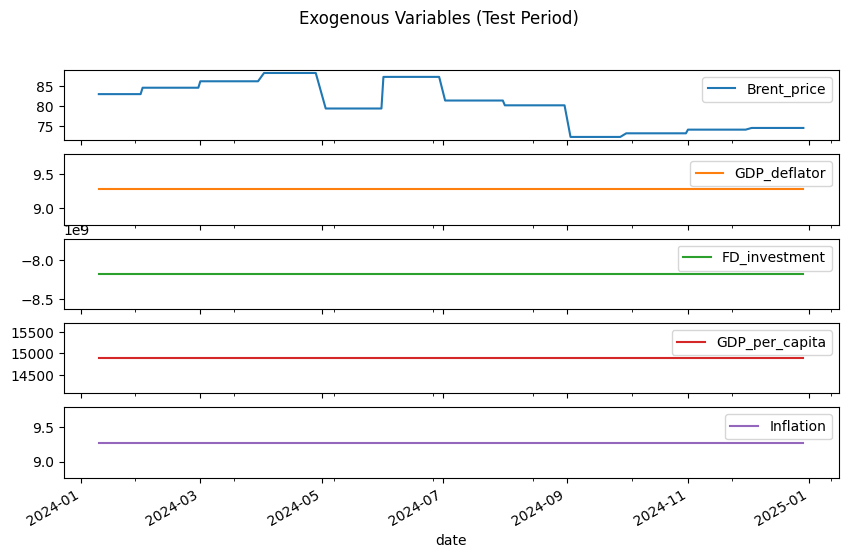

In [144]:
exog_test.plot(subplots=True, figsize=(10, 6))
plt.suptitle("Exogenous Variables (Test Period)")
plt.show()

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

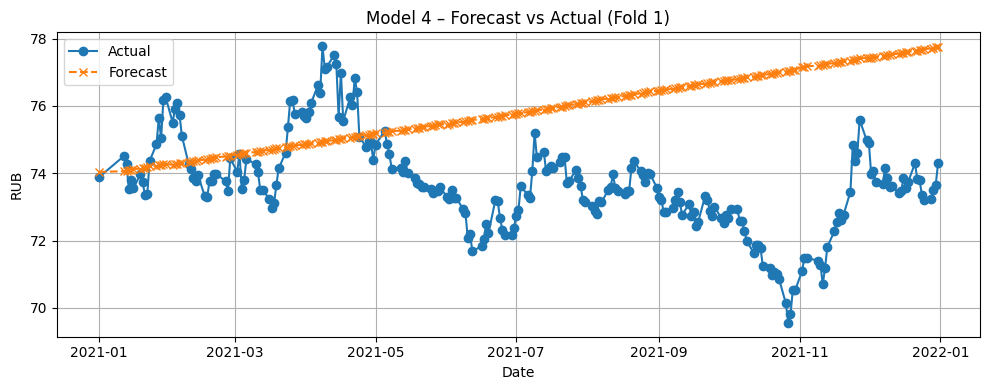

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

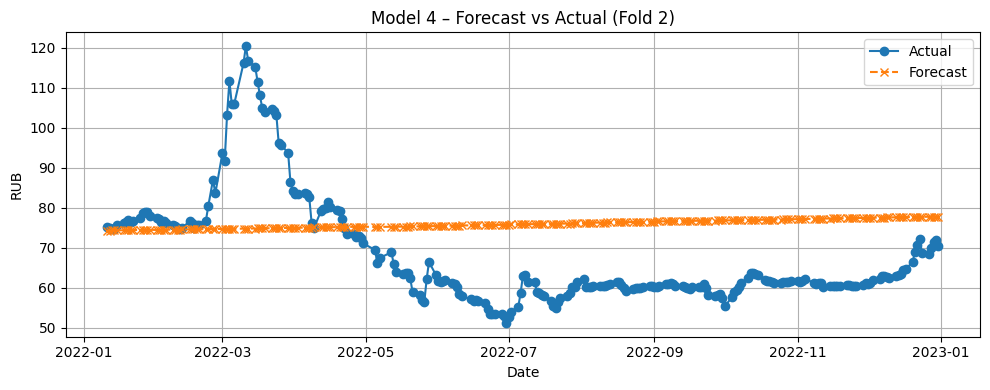

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

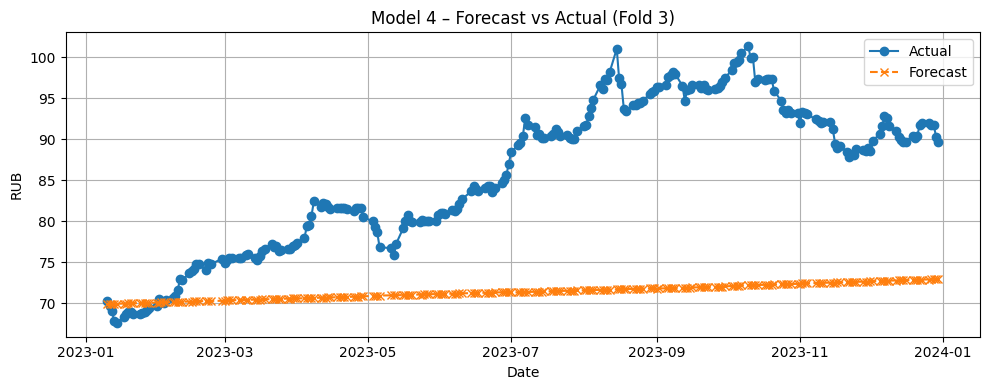

/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/anaconda3/envs/jlab/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

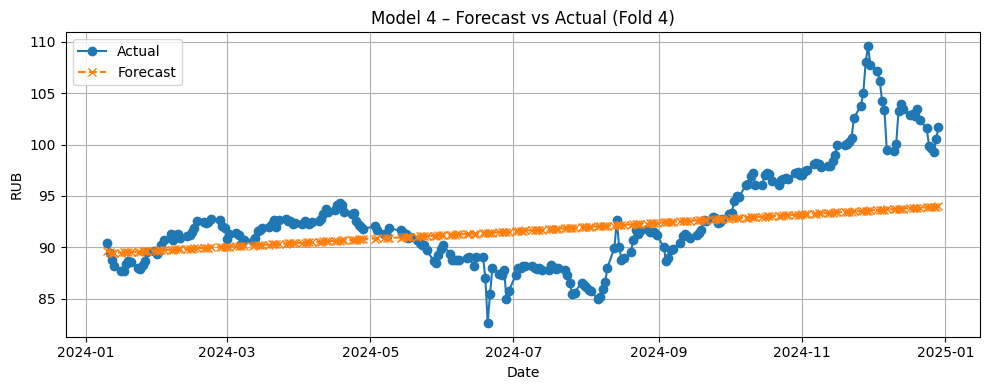

In [146]:
for i in range(1, 5):
    train_mask = data_work[f"train{i}"]
    test_mask = data_work[f"test{i}"]

    y_train = data_work.loc[train_mask, "RUB"].sort_index()
    y_test = data_work.loc[test_mask, "RUB"].sort_index()

    # Exogenous variables for train and test (must match y_train/y_test indices)
    exog_train = exog_all.loc[train_mask].sort_index()
    exog_test = exog_all.loc[test_mask].sort_index()

    # Fit ARIMAX model
    model_4 = ARIMA(endog=y_train, exog=exog_train, order=best_order, trend='t').fit()

    # Forecast for the test period using exogenous variables
    phat = model_4.forecast(steps=len(y_test), exog=exog_test)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test.values, label="Actual", marker='o')
    plt.plot(y_test.index, phat.values, label="Forecast", linestyle='--', marker='x')
    plt.title(f"Model 4 – Forecast vs Actual (Fold {i})")
    plt.xlabel("Date")
    plt.ylabel("RUB")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()